##Ephemeris Generation##

This notebook is intended to test various methods of generating the positions and velocities of moving objects, including testing the accuracy of the resulting values calculated by interpolating between the points calculated by an n-body integrator. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import interpolate
import pandas as pd

from itertools import repeat
import pyoorb as oo


In [20]:
def _updateColMap(colMap, outCol, alternativeNames, ssoCols):
    for a in alternativeNames:
        if a in ssoCols:
            colMap[outCol] = a
    return colMap

def readOrbits(orbitfile='pha20141031.des'):
    """
    Read the orbits from file 'orbitfile', returning a numpy structured array with the columns:
    'objID q e inc node argPeri tPeri epoch H g a meanAnom'
    """
    orbits = pd.read_table(orbitfile, sep='\s*', engine='python')
    # Normalize the column names, as different inputs tend to have some commonly-different names. 
    ssoCols = orbits.columns.values.tolist()
    nSso = len(orbits)
    outCols = ['objId', 'q', 'e', 'inc', 'node', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'a', 'meanAnom']
    # Create mapping between column names read from disk and desired column names.
    colMap = {}
    for o in outCols:
        if o in ssoCols:
            colMap[o] = o
        else:
            # Try to find corresponding value
            if o == 'objId':
                alternatives = ['!!ObjID','objid', '!!OID']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'inc':
                alternatives = ['i']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'node':
                alternatives = ['BigOmega', 'Omega/node', 'Omega']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'argPeri':
                alternatives = ['argperi', 'omega/argperi']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'tPeri':
                alternatives = ['t_p', 'timeperi']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'epoch':
                alternatives = ['t_0']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'H':
                alternatives = ['magH', 'magHv', 'Hv']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'g':
                alternatives = ['phaseV', 'phase', 'gV']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'a':
                alternatives = ['semimajor']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
            elif o == 'meanAnom':
                alternative = ['meanAnomaly', 'meananomaly', 'M']
                colMap = _updateColMap(colMap, o, alternatives, ssoCols)
                
    # Add the columns we can generate. 
    if 'objId' not in colMap:
        orbids = np.arange(0, nSso, 1)
    else:
        orbids = orbits[colMap['objId']]
    if 'H' not in colMap:
        Hval = np.zeros(nSso) + 20.0
    else:
        Hval = orbits[colMap['H']]
    if 'g' not in colMap:
        gval = np.zeros(nSso) + 0.15
    else:
        gval = orbits[colMap['g']]
    
    # And some columns that can be converted from different orbit types.
    if 'a' not in colMap:
        aval = orbits[colMap['q']] / (1 + orbits[colMap['e']])
    else:
        aval = orbits[colMap['a']]
    period = np.sqrt(aval**3)
    if 'meanAnom' not in colMap:
        meanAnomval = 360.0*(orbits[colMap['epoch']] - orbits[colMap['tPeri']]) / (period*365.25)
    else:
        meanAnomval = orbits[colMap['meanAnom']]
    if 'q' not in colMap:
        qval = orbits[colMap['a']] * (1 - orbits[colMap['e']])
    else:
        qval = orbits[colMap['q']]
    if 'tPeri' not in colMap:
        tPerival = orbits[colMap['epoch']] - (orbits[colMap['meanAnom']]/360.0) * (period*365.25)
    else:
        tPerival = orbits[colMap['tPeri']]
        
    # Put it all together and turn it into a numpy array. 
    orbits = np.rec.fromarrays([orbids, qval, orbits[colMap['e']], orbits[colMap['inc']],
                                 orbits[colMap['node']], orbits[colMap['argPeri']], tPerival,
                                 orbits[colMap['epoch']], Hval, gval, aval, meanAnomval], 
                                names = outCols)
    return orbits

In [21]:
orbits = readOrbits()
print orbits.dtype.names

('objId', 'q', 'e', 'inc', 'node', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'a', 'meanAnom')


In [22]:
# Set up to run OpenOrb to generate ephemerides.
oo.pyoorb.oorb_init(ephemeris_fname="")

1

Set up the times at which to calculate 'rough' positions. 
We will interpolate between these times to find the positions at the actual time of a visit. 

In [23]:
def setTimes(timestep=1., nyears=1., timestart=49353.):
    # Extend times beyond first/last observation, so that interpolation doesn't fail
    timestart = timestart - timestep
    timeend = timestart + 365 * nyears + timestep 
    times = np.arange(timestart, timeend + timestep/2.0, timestep)
    # For pyoorb, we need to tag times with timescales;
    # 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
    ephTimes = np.array(zip(times, repeat(4, len(times))), dtype='double', order='F')
    return ephTimes

Python oorb element format: 
        # 
        # 0: orbitId  (cannot be a string)
        # 1 - 6: orbital elements, using radians for angles
        # 7: element type code, where 2 = cometary - means timescale is TT, too
        # 8: epoch
        # 9: timescale for the epoch; 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
        # 10: magHv
        # 11: G
        #
so we have to do a little translating from the orbits DataFrame to the elements we want in this array. 

In [37]:
def packOorbElem(sso):
    """
    Convert numpy structured array of orbital elements into the array OpenOrb needs as input.
    'sso' can be the orbital elements of a single object or of multiple objects.
    To normalize the column names to those expected here, read in data using 'readOrbits'.
    """
    if len(sso.shape) == 0:
        # Passed a single SSO
        nSso = 0
        sso0 = sso
        elem_type = 2
        epoch_type = 3
    else:
        nSso = len(sso)
        sso0 = sso[0]        
        elem_type = np.zeros(nSso) + 2
        epoch_type = np.zeros(nSso) + 3
    # Check on orbit id type - pyoorb needs numbers not strings.
    if (isinstance(sso0['objId'], float) or isinstance(sso0['objId'], int)):
        orbids = sso['objId']
    else:
        if nSso == 0:
            orbids = 0
        else:
            orbids = np.arange(0, nSso, 1)
    # Convert to format for pyoorb, INCLUDING converting inclination, node, argperi to RADIANS
    oorbArray = np.column_stack((orbids, sso['q'], sso['e'], np.radians(sso['inc']),
                                 np.radians(sso['node']), np.radians(sso['argPeri']),
                                 sso['tPeri'], elem_type, sso['epoch'], epoch_type, 
                                 sso['H'], sso['g']))                                            
    return oorbArray

Python oorb ephem array format:

        #   [objid][time][ephemeris information @ that time]
        # 0 = distance (geocentric distance)
        # 1 = ra (deg)
        # 2 = dec (deg)
        # 3 = mag
        # 4 = ephem mjd
        # 5 = ephem mjd timescale
        # 6 = dra/dt (deg/day) sky motion
        # 7 = ddec/dt (deg/day) sky motion
        # 8 = phase angle (deg)
        # 9 = solar elongation angle (deg)
        
So usually we want to swap the axes at least, so that instead of all the ephemeris information @ a particular time being the accessible bit of information, we have all the RA values over time for a single object ('byObject')
Alternatively, we may want all the RA values for all objects at one time. This is also an option, by setting 'byObject' to False.

In [38]:
def unpackEphs(oorbephems, byObject=True):
    """
    Given oorb ephemeris array (shape = object / times / eph@time),
    Return an array aranged with 
     columns = ['delta', 'ra', 'dec', 'mag', 'time', 'timescale', 'dradt', 'ddecdt', 'phase', 'solarelon']
     as the second
    grouped either by object (i.e. length of ra array == length of times) (default)
    or grouped by time (i.e. length of ra array == number of objects) (if byObject not true).
    """
    ephs = np.swapaxes(oorbephems, 2, 0)
    # oorbcols=['delta', 'ra', 'dec', 'magV', 'time', 'timescale', 'dradt', 'ddecdt', 'phase', 'solarelon']
    velocity = np.sqrt(ephs[6]**2 + ephs[7]**2)
    if byObject:
        ephs = np.swapaxes(ephs, 2, 1)
        velocity = np.swapaxes(velocity, 1, 0)
    # Create numpy structured array
    ephs = np.rec.fromarrays([ephs[0], ephs[1], ephs[2], ephs[3], ephs[4], 
                              ephs[6], ephs[7], ephs[8], ephs[9], velocity], 
                             names=['delta', 'ra', 'dec', 'magV', 'time', 'dradt', 
                                    'ddecdt', 'phase', 'solarelon','velocity'])
    return ephs

Interpolate between calculated ephemerides. This is where Steve Chesley suggests to use chevyshev polys instead of linear interpolation (thus letting us use bigger timesteps in the initial ephemeride generation). 

In [53]:
# Linear interpolation
def interpolateEphs(ephs, i=0):
    interpfuncs = {}
    for n in ephs.dtype.names:
        if n == 'time':
            continue
        interpfuncs[n] = interpolate.interp1d(ephs['time'][i], ephs[n][i], kind='linear', 
                                              assume_sorted=True, copy=False)
    return interpfuncs

In [54]:
orbsubset = orbits[0:50]
ephTimes = setTimes()

In [55]:
oorbelems = packOorbElem(orbsubset)
oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
ephs = unpackEphs(oorbephs)

In [45]:
%%timeit
oorbelems = packOorbElem(orbsubset)
oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
ephs = unpackEphs(oorbephs)

1 loops, best of 3: 3.95 s per loop


In [46]:
%%timeit
for sso in orbsubset:
    oorbelems = packOorbElem(sso)
    oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephs)

1 loops, best of 3: 4.15 s per loop


It is indeed slightly faster (2.4s vs 2.55s for 30 objects, 7.9s vs 8.2s for 100 objects, 15.7s vs 16.6s for 200 objects) to calculate ephemerides for the combined set, rather than cycle through each one individually. However, there must be some balance here when considering many many objects, over a long time period (i.e. when doing big simulations for MAF or other purposes), as holding so many ephemerides in memory could be too big. 

[ 0.005   0.004   0.0047  0.0045] [ 0.08    0.079   0.079   0.0785]
Per object, grouping objects rather than looping is 5.74878557607 % faster.
 (difference is about  0.00455 s faster, out of 0.079125 s total time


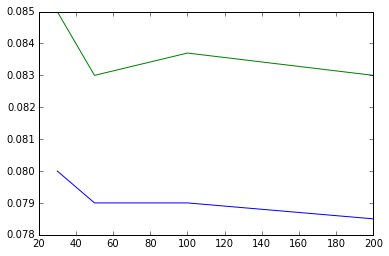

In [47]:
a = np.array([2.4, 3.95, 7.9, 15.7])
b = np.array([2.55, 4.15, 8.37, 16.6])
x = np.array([30, 50, 100, 200])
plt.plot(x, a/x)
plt.plot(x, b/x)
print (b/x - a/x), a/x
print 'Per object, grouping objects rather than looping is', np.mean((b/x-a/x) / (a/x) * 100), '% faster.'
print ' (difference is about ', np.mean(b/x-a/x), 's faster, out of', np.mean(a/x), 's total time'

In [49]:
orbitfile = 'pha20141031.des'
#orbitfile = 'ssm_1000/tnos_1000'

orbits = readOrbits(orbitfile)

ephTimes = setTimes(timestep=3/24.0, nyears=1)

for orb in orbits[0:1]:
    oorbelems = packOorbElem(orb)
    oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephs)
    interpfuncs = interpolateEphs(ephs)

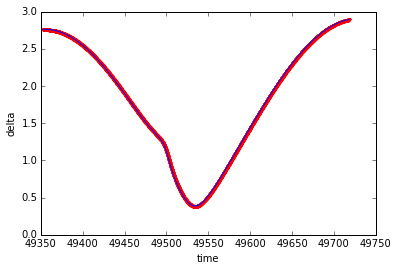

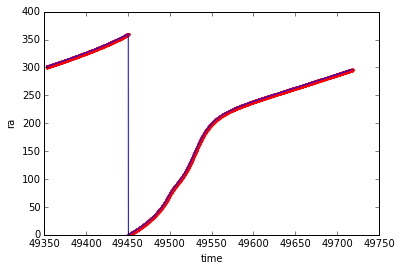

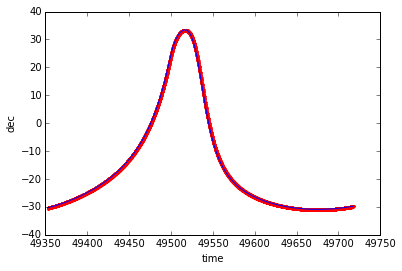

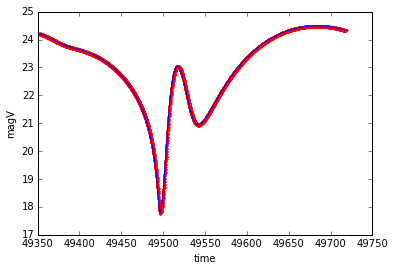

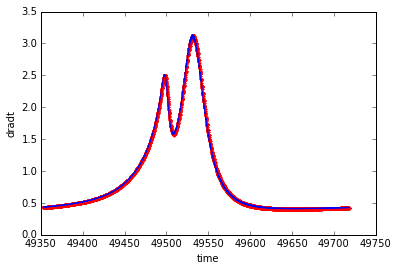

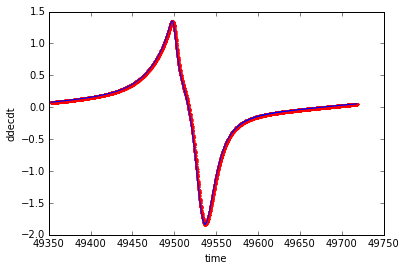

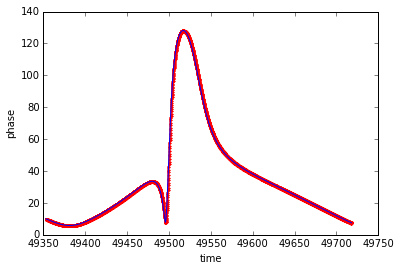

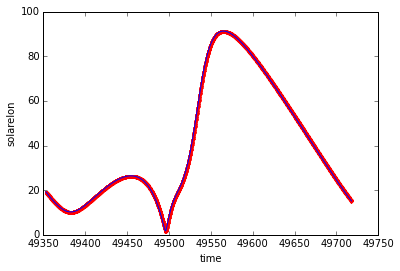

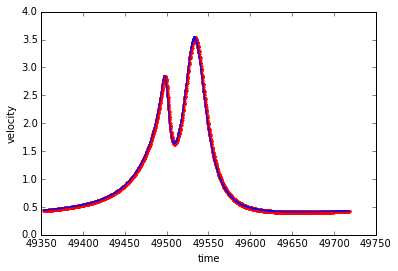

In [51]:
for col in ephs.dtype.names:
    if col == 'time':
        continue
    plt.figure()
    plt.plot(ephs['time'][0], ephs[col][0], 'r.')
    if col in interpfuncs:
        plt.plot(ephs['time'][0], interpfuncs[col](ephs['time'][0]), 'b-')
    plt.xlabel('time')
    plt.ylabel(col)

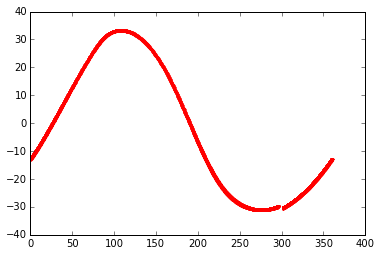

In [52]:
plt.plot(ephs['ra'][0], ephs['dec'][0], 'r.')

In [56]:
print interpfuncs.keys()

['magV', 'dradt', 'solarelon', 'ra', 'delta', 'phase', 'velocity', 'ddecdt', 'dec']
